In [16]:
%load_ext autoreload
%autoreload 2
import torch
import zipfile
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ModelStructures import select_model

np.random.seed(1)
torch.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, transform=None):
        """
        Args:
            data_frame: contains needed info about loading files
            root_dir (string): base directory path for images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # image path is in column 0
        image = Image.open(self.data_frame.iloc[idx, 0])
        label = self.data_frame.iloc[idx]['label_encoded']
        
        if self.transform: # Transform image if applicable
            image = self.transform(image)

        return (image, label) # return tuple

In [18]:
import os
import glob
from sklearn.preprocessing import LabelEncoder # For numeric labeling

dataset_id = 'Grozi'

if dataset_id == 'Grozi':
#     base_path = 'C:/Users/pwest/Downloads/Grozi3.2k_Grocery_products/Grocery_products/Training'
    base_path = './Training.zip'
    val_path = None
elif dataset_id == 'GroceryStoreDataset': # Too simple of dataset
    base_path = 'C:/Users/pwest/Documents/GroceryStoreDataset/dataset/train'
    val_path = None
elif dataset_id == 'Freiburg':
#     base_path = 'C:/Users/pwest/Documents/FreiburgDataset/images'
    base_path = './images.zip'
    val_path = None
else:
    raise ValueError('Incorrect Dataset ID')

# Get training data file paths
def create_image_dataframe(base_path):
    if base_path:
        
        if '.zip' in base_path:
            zip_arch = zipfile.ZipFile(base_path, 'r')
            zip_arch.extractall()
            zip_arch.close()
            base_path = base_path.replace('.zip', '')
            print(base_path)
            
        train_files = glob.glob(base_path + '/**/*.jpg', recursive=True) # path to all .jpg
        train_files = train_files + glob.glob(base_path + '/**/*.png', recursive=True) # path to all .png
        train_files = train_files + glob.glob(base_path + '/**/*.PNG', recursive=True) # .PNG
        train_files = train_files + glob.glob(base_path + '/**/*.JPG', recursive=True) # .JPG
        
        # Get data in dataframe
        file_dicts = []
        for f in train_files:
            f_dict = {}
            f_dict['img_path'] = f # get image path
            try:
                Image.open(f)
            except:
                continue
            split_list = f.split('/')
            if len(split_list) <= 1:
                split_list = f.split('\\')
            num_elems = len(split_list)
            new_path = '_'.join(split_list[1:(num_elems-1)])
            f_dict['img_name'] = new_path + '_' + split_list[-1]
            new_path = new_path.replace('Training_', '')
            new_path = new_path.replace('images_', '')
            f_dict['label'] = new_path
            if 'Background' not in f_dict['label']:
                file_dicts.append(f_dict)

        # Create Dataframe and encode labels    
        image_frame = pd.DataFrame(file_dicts)
        le = LabelEncoder()
        label_encoded = le.fit_transform(image_frame['label'])
        image_frame['label_encoded'] = label_encoded
        return image_frame
    
    else:
        return
    
train_frame = create_image_dataframe(base_path)
val_frame = create_image_dataframe(val_path)
print(len(train_frame['label_encoded'].unique()), len(train_frame.index))
keys_mapped = train_frame[['label', 'label_encoded']].copy().drop_duplicates()
keys_mapped.to_csv('my_grozi_mappings.csv')
train_frame.head()

./Training
80 8349


,img_path,img_name,label,label_encoded
0,./Training/HouseProducts/Batteries/783.jpg,Training_HouseProducts_Batteries_783.jpg,HouseProducts_Batteries,46
1,./Training/HouseProducts/Batteries/776.jpg,Training_HouseProducts_Batteries_776.jpg,HouseProducts_Batteries,46
2,./Training/HouseProducts/Batteries/779.jpg,Training_HouseProducts_Batteries_779.jpg,HouseProducts_Batteries,46
3,./Training/HouseProducts/Batteries/801.jpg,Training_HouseProducts_Batteries_801.jpg,HouseProducts_Batteries,46
4,./Training/HouseProducts/Batteries/alk.jpg,Training_HouseProducts_Batteries_alk.jpg,HouseProducts_Batteries,46


In [20]:
# Select Model and Load Data
from sklearn.model_selection import StratifiedShuffleSplit

model_select = 'mobilenet'
optim_select = 'adam' # NOTE: adam struggles with vgg16. SGD worked well!
batch_size = 16
pre_train = True # Do we initialize with pre-trained weights?
fine_tune = True # If true: retrain top two layers, if false: only fc layers. NOTE: init=true overrides this
init = True # If true: re-train all layers, if false: nothing
num_classes = len(train_frame['label_encoded'].unique())   
model, t_forms, optimizer, scheduler = select_model(model_select, num_classes, 
                                                    optim_select=optim_select, 
                                                    pre_train=pre_train, 
                                                    fine_tune=fine_tune, 
                                                    init=init)

# Where should we store our outputs?
path_store = './Outputs/' + model_select + '/' + optim_select + '/' + \
            'fine_tune=' + str(fine_tune) + '_pretrain=' + str(pre_train) + \
            '_init=' + str(init)

loss_fn = nn.CrossEntropyLoss()

# Create Datasets
if val_frame is None:
    from math import floor
    t_copy = train_frame.copy()
    val_split_percent = 0.1

    # Evenly split out classes
    frame_split = StratifiedShuffleSplit(n_splits=1, test_size=val_split_percent,
                                        random_state=10)
    for train_index, test_index in frame_split.split(t_copy, t_copy['label_encoded']):
        train_data = t_copy.loc[train_index]
        val_data = t_copy.loc[test_index]
        
    assert not pd.Series(train_data.index).isin(val_data.index).any()
    val_set = CustomImageDataset(val_data, transform=t_forms['val'])
    train_set = CustomImageDataset(train_data, transform=t_forms['train'])
else:
    # Ensure labels match between dataframes
    train_set = CustomImageDataset(train_frame, transform=t_forms['train'])
    val_set = CustomImageDataset(val_frame, transform=t_forms['val'])

# Create loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                          pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False,
                                        pin_memory=True, num_workers=4)

In [21]:
'''
Run a single epoch of model training
'''
def train_model(model, loss_fn, optimizer, train_loader, val_loader, device):
    epoch_loss = 0
    model.train()
    for train_sample in train_loader:
        images = train_sample[0].to(device)
        labels = train_sample[1]
        labels = train_sample[1].type(torch.LongTensor).to(device)

        predict_out = model(images) # Predicted output
        loss = loss_fn(predict_out, labels) # Calculate loss
        epoch_loss += loss.item() # Loss tally

        optimizer.zero_grad() # Zero gradient
        loss.backward() # Backpropogate to learn
        optimizer.step() # Step forward
        del train_sample, images, labels, predict_out, loss
        
    with torch.no_grad():
        val_accuracy, val_accuracy_5, val_loss = test_model(model, loss_fn, val_loader, device)

    train_loss = epoch_loss / len(train_loader)

    return train_loss, val_accuracy, val_accuracy_5, val_loss

In [22]:
'''
Run a single epoch of model testing
This function can also be used to run an iteration of validation
'''
def test_model(model, loss_fn, t_loader, device):
    count_correct = 0 # Top 1 Accuracy
    count_correct_5 = 0 # Top 5 Accuracy
    total_count = 0
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for test_sample in t_loader:
            images_test = test_sample[0].to(device)
            labels_test = test_sample[1].type(torch.LongTensor).to(device)
            labels_test_flat = labels_test.flatten()
            labels_test_flat = labels_test_flat.type(torch.LongTensor).to(device)
            
            # Predict and calculate loss
            predict_test = model(images_test)
            predict_5 = predict_test.topk(k=5, dim=1, sorted=True) # For top 5 accuracy
            loss = loss_fn(predict_test, labels_test)
            
            # Top 1 accuracy
            labels_pred = predict_test.data.max(1, keepdim=True)[1] # Get max value
            labels_pred_flat = labels_pred.flatten() # Flatten results for comparison
            count_correct += (labels_pred_flat == labels_test_flat).sum().item()
            total_count += len(labels_test)
            
            # Top 5 accuracy
            for idx, top_5 in enumerate(predict_5[1]):
                if labels_test_flat[idx] in top_5:
                    count_correct_5 += 1
            
            test_loss += loss.item()
            del images_test, labels_test, labels_test_flat, test_sample, \
                predict_test, labels_pred
    
    testing_accuracy = count_correct / total_count
    testing_accuracy_5 = count_correct_5 / total_count
    testing_loss = test_loss / len(t_loader)
    
    return testing_accuracy, testing_accuracy_5, testing_loss

In [23]:
# Prepare for training
import time
import math
import os
start = time.time()

# Set device and send model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Loss/Accuracy Vectors
train_loss = []
val_accuracy = []
val_accuracy_5 = []
val_loss = []

# Determine parameters for epochs/early stopping
if pre_train:
    epochs = 50 if optim_select != 'sgd' else 60
#     epochs = 50 if optim_select != 'sgd' else 100 # Trying 100 for SGD
    patience_scaler = 0.65 if optim_select == 'sgd' else 0.4
    patience_terminate = 10 if optim_select == 'SGD' else 6
else:
    epochs = 100
    patience_scaler = 0.7 if optim_select == 'sgd' else 0.6
    patience_terminate = 10 if optim_select == 'SGD' else 6
patience = math.ceil(patience_scaler * epochs) # When to consider early stopping
val_loss_counter = 0 # Early Stopping Counter
min_loss = (0, 1000, None) # Epoch, min_loss, ckpt path

# Final path store update
path_store = path_store + '/epochs=' + str(epochs) + '/'

# create directory if it doesn't exist
if not os.path.exists(path_store):
    os.makedirs(path_store)

cuda


In [24]:
# Check if we have a checkpoint, load if we do
iters = range(epochs) # Base iterator
cpt_files = glob.glob(path_store + '*.pt')
try:
    latest_file = max(cpt_files, key=os.path.getctime) # Most recent .pt file
    print('Loading Previous Checkpoint: ' + latest_file)
    trained_model = torch.load(latest_file)
    model.load_state_dict(trained_model['model_state_dict'])
    optimizer.load_state_dict(trained_model['optimizer_state_dict'])
    e = trained_model['epoch']
    iters = range(e, epochs) # Update iters
    min_loss = trained_model['best_epoch'] # Update min loss
    train_loss = trained_model['train_loss'] # Update train loss
    val_loss = trained_model['val_loss'] # Update val loss
    val_accuracy = trained_model['val_accuracy'] # Update val accuracy
    val_accuracy_5 = trained_model['val_accuracy_5'] # Update top 5
except:
    pass
    
for i in iters:
    epoch_loss, epoch_accuracy, epoch_accuracy_5, epoch_val_loss = \
        train_model(model, loss_fn, optimizer, train_loader, val_loader, device)
    
    train_loss.append(epoch_loss)
    val_accuracy.append(epoch_accuracy)
    val_accuracy_5.append(epoch_accuracy_5)
    val_loss.append(epoch_val_loss)
    
    print('Epoch ' + str(i+1) + ': Train Loss=' + str(round(epoch_loss, 4)) + \
          ', Validation Loss=' + str(round(epoch_val_loss, 4)) + \
          ', Validation Accuracy=' + str(round(epoch_accuracy, 4)) + \
          ', Top 5 Accuracy=' + str(round(epoch_accuracy_5, 4)) + \
          ', time=' + str(round(time.time() - start, 4)))
    
    # Save checkpoint, we will want best results!
    cpt_path = path_store + 'chkpt_' + str(i+1) + '_training.pt'
    torch.save({'epoch':i+1, 'min_loss':min_loss,
                'model_state_dict':model.state_dict(),
               'optimizer_state_dict':optimizer.state_dict(),
               'train_loss':train_loss,
               'val_loss':val_loss,
                'val_accuracy':val_accuracy,
                'val_accuracy_5':val_accuracy_5,
               'best_epoch':min_loss}, cpt_path)
    
    if epoch_val_loss < min_loss[1]:
        min_loss = (i+1, epoch_val_loss, cpt_path) # Update
        val_loss_counter = 0 # Reset counter if we make progress
    
    if epoch_val_loss > min_loss[1] and (i+1) >= patience:
        val_loss_counter += 1    
        if val_loss_counter == 10:
            print('Terminated training at epoch=' + str(i + 1))
            break
    
    if scheduler is not None:
        scheduler.step(epoch_val_loss) # Iterate scheduler

print('Best Results (epoch, loss): ' + str(min_loss[:2]))

Epoch 1: Train Loss=3.6717, Validation Loss=2.0251, Validation Accuracy=0.4922, Top 5 Accuracy=0.7677, time=38.6161
Epoch 2: Train Loss=2.1848, Validation Loss=1.5892, Validation Accuracy=0.5988, Top 5 Accuracy=0.8251, time=77.6069
Epoch 3: Train Loss=1.832, Validation Loss=1.438, Validation Accuracy=0.6228, Top 5 Accuracy=0.8563, time=116.9643
Epoch 4: Train Loss=1.6171, Validation Loss=1.2532, Validation Accuracy=0.679, Top 5 Accuracy=0.891, time=156.0222
Epoch 5: Train Loss=1.48, Validation Loss=1.2407, Validation Accuracy=0.6886, Top 5 Accuracy=0.8874, time=195.684
Epoch 6: Train Loss=1.3507, Validation Loss=1.1933, Validation Accuracy=0.685, Top 5 Accuracy=0.9066, time=235.1045
Epoch 7: Train Loss=1.2501, Validation Loss=1.0981, Validation Accuracy=0.7114, Top 5 Accuracy=0.9162, time=274.3681
Epoch 8: Train Loss=1.1583, Validation Loss=1.1567, Validation Accuracy=0.7042, Top 5 Accuracy=0.909, time=314.2268
Epoch 9: Train Loss=1.0679, Validation Loss=1.1654, Validation Accuracy=0.7

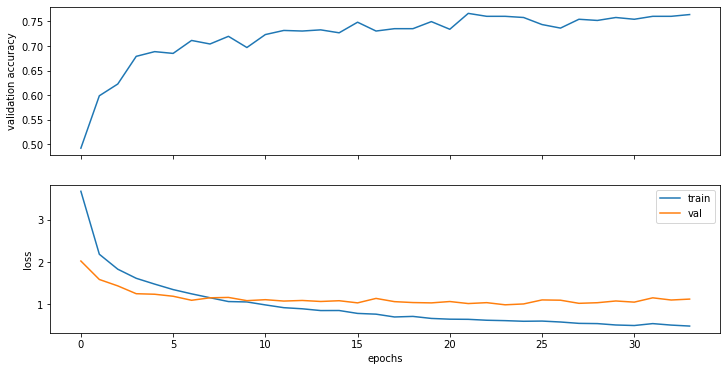

In [25]:
# Convert to numpy
epoch_array = np.arange(1, i+2)
train_loss = np.array(train_loss)
val_accuracy = np.array(val_accuracy)
val_accuracy_5 = np.array(val_accuracy_5)

val_loss = np.array(val_loss)
data_df = pd.DataFrame({'epoch':epoch_array,
                       'train_loss':train_loss,
                       'val_accuracy':val_accuracy,
                       'top_5_accuracy':val_accuracy_5})

# Write out data
data_df.to_csv(path_store + 'AMATH563_Project_' + model_select + '_' + dataset_id + '_' + \
               str(epochs) + '_epochs.csv', 
               index=False)

# Plot Results
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(val_accuracy)
ax1.set_ylabel("validation accuracy")
ax2.plot(train_loss)
ax2.plot(val_loss)
ax2.legend(['train', 'val'])
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")

# Restore best performing model
checkpoint = torch.load(min_loss[2])
model.load_state_dict(checkpoint['model_state_dict'])

# Save Best Performing Trained Model
model_name = path_store + 'AMATH563_Project_' + model_select + '_' + dataset_id + '_trained.pth'
torch.save(model.state_dict(), model_name)
torch.cuda.empty_cache() # Clear GPU memory after saving

# Clear out checkpoint files
for f in glob.glob(path_store + '*.pt'):
    if f.endswith('.pt'):
        os.remove(f)

# Clear out unzipped directories
import shutil
for p in ['./Training/', './images/']:
    if os.path.exists(p):
        shutil.rmtree(p)

In [26]:
fig.savefig(path_store + model_select + '_' + dataset_id + '_' + str(epochs)  + '_epochs.png')